In [532]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch

In [533]:
device = "cuda" if torch.cuda.is_available() else "cpu"

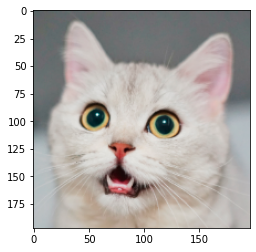

In [534]:
# load an example image

from PIL import Image
import torchvision.transforms.functional as TF

image_path = "../data/samples/cat.png"
image = Image.open(image_path).convert('RGB')

plt.imshow(image)

In [585]:
# transforms of pretrained models

from torchvision import transforms
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#    normalize
])

x = transform(image).unsqueeze(0).to(device)
print(x.shape)

torch.Size([1, 3, 224, 224])


In [586]:
# get a pre-trained model

import torchvision.models as models
model = models.vgg16_bn(pretrained=True)
model = model.to(device)

In [587]:
# load ImageNet class dict

classes_path = "../data/samples/ImageNet_1000_classes.pkl"

with open(classes_path, "rb") as f:
    classes = pkl.load(f)

In [588]:
model.eval()
output = model(x)
pred_class = torch.argmax(output, dim=1)
print(classes[pred_class.item()])

assert classes[pred_class.item()] == 'tabby, tabby cat'

tabby, tabby cat


In [615]:
import torch.nn as nn

def untargeted_fgsm_attack(image, label, model, eps = 0.25):
    
    loss_f = nn.CrossEntropyLoss()

    adv_image = image.clone().detach()
    adv_image.requires_grad = True

    output = model(adv_image)
    loss = loss_f(output, label)
    model.zero_grad()
    loss.backward()

    adv_image = adv_image + eps * adv_image.grad.data.sign()
    adv_image = torch.clamp(adv_image, min=0, max=1).detach()

    return adv_image
    

In [625]:
# generate an adversarial example
cat_idx = 285
label = torch.tensor([cat_idx]).to(device)
eps = 0.20

adv_image_tensor = untargeted_fgsm_attack(x, label, model, eps)
adv_image_tensor.shape

torch.Size([1, 3, 224, 224])

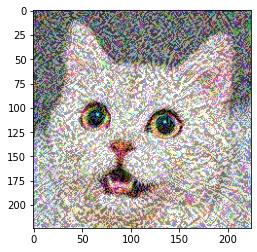

In [626]:
adv_image = adv_image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()

plt.imshow(adv_image)

In [627]:
model.eval()
output = model(adv_image_tensor)
pred_class = torch.argmax(output, dim=1)
classes[pred_class.item()]

'envelope'